First of all, the necessary libraries:

In [287]:
%matplotlib inline
#pytorch packages 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
#To download the dataset for torchvision
import torchvision
from torchvision import datasets, transforms
#For plots
import matplotlib.pyplot as plt

# Download and look at the data

For this example, we will try to recognize hand-written digits, specifically the ones of the MNIST dataset, that contains overall 70,000 28-by-28-pixels pictures of hand-written digits. This dataset is easily accessible in pytorch via dataset.MNSIT. You just have to specify you want to download it if it's not already in the directory, and pytorch will process it to create a DataSet.

In [2]:
#Change to the directory of your choice.
PATH = '.'

Grab the training and the test set.

In [5]:
trn_set = datasets.MNIST(PATH, train=True, download=True)
tst_set = datasets.MNIST(PATH, train=False, download=True)

Let's have a look at the data in the training set first.

In [290]:
len(trn_set.train_data), len(tst_set.test_data)

(60000, 10000)

Each image is represented by a tensor of size 28 by 28, each value represents the color of the corresponding pixel, from 0 (black) to 255 (white). Torch tensors are the equivalent of numpy ndarrays.

In [291]:
trn_set.train_data[0]



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     3
    0     0     0     0     0     0     0     0    30    36    94   154   170
    0     0     0     0     0     0     0    49   238   253   253   253   253
    0     0     0     0     0     0     0    18   219   253   253   253   253
    0     0     0     0     0     0     0     0    80   156   107   253   253
    0     0     0     0     0     0     0     0     0    14     1   154   253
    0     0     0     0     0     0     0     0     0     0     0   139   253
    0     0     0     0     0     0     0    

It's easy to convert a torch tensor to a numpy array via the .numpy() command.

Conversely, you can create a torch Tensor from a numpy array x via torch.Tensor(x)

In [292]:
trn_set.train_data[0].numpy()

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

It's then easy to see the corresponding picture via plt.

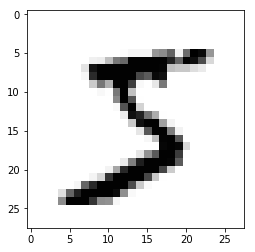

In [293]:
plt.imshow(trn_set.train_data[0].numpy(), cmap='Greys')

Let's have a look at the corresponding label...

In [294]:
trn_set.train_labels[0]

5

# Preparing the data

A pytorch neural network will expect the data to come in the form of minibatches of tensors. To do that, we use a pytorch object called DataLoader. It will randomly separate the pictures (with the associated label) in minibatches. If you have multiple GPUs, it also prepares the work to be parallelized between them (just change num_workers from 0 to your custom value). We only shuffle the data randomly for the training.

First we need to explicitely ask our dataset to transform the images in tensors.

In [299]:
tsfms = transforms.ToTensor()
trn_set = datasets.MNIST(PATH, train=True, download=True, transform=tsfms)
tst_set = datasets.MNIST(PATH, train=False, download=True, transform=tsfms)

In [300]:
trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=64, shuffle=True, num_workers=0)
tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=64, shuffle=False, num_workers=0)

Let's have a look at an example. A data loader can be converted into an iterator and we can then ask him for a minibatch.

In [301]:
mb_example = next(iter(trn_loader))

Such a minibacth containts two torch tensors: the first one contains the data (here our pictures) and the second one the expected labels.

In [302]:
mb_example[0].size(), mb_example[1].size()

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Note that pytorch has automatically added one dimension to our images (the 1 in second position). It would be 3 if we had had the three usual channels for the colors (RGB). Pytorch puts this channel in the second dimension and not the last because it simplifies some computation.

Let's see the first tensor.

In [307]:
mb_example[0][0,0]



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0314
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1529
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1529
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1529
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0706
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.000

Note that pytorch transformed the values that went from 0 to 255 into floats that go from 0. to 1.

We can have a look at the first pictures and draw them.

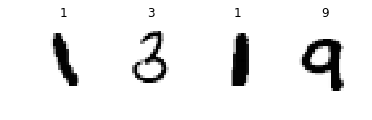

In [306]:
fig = plt.figure()
for i in range(0,4):
    sub_plot = fig.add_subplot(1,4,i+1)
    sub_plot.axis('Off')
    plt.imshow(mb_example[0][i,0].numpy(), cmap='Greys')
    sub_plot.set_title(mb_example[1][i])

Another usual transformation we do before feeing the pictures to our neural network is to normalize the input. This means subtracting the mean and dividing by the standard deviation. We can either search for the usual values on Google or compute them from scratch.

In [308]:
mean = torch.mean(trn_set.train_data.type(torch.FloatTensor))/255.
std = torch.std(trn_set.train_data.type(torch.FloatTensor))/255.
mean,std

(0.1306604762738429, 0.30810780717887876)

We divide by 255 to get the means of our data when it's convereted into floats from 0. to 1.

Then we go back to creating a transfrom and add the normalization. Note that we use the same mean and std for the test set. Afterward, we reload our datasets, adding this transform.

In [313]:
tsfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])
trn_set = datasets.MNIST(PATH, train=True, download=True, transform=tsfms)
tst_set = datasets.MNIST(PATH, train=False, download=True, transform=tsfms)

In [314]:
trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=64, shuffle=True, num_workers=0)
tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=64, shuffle=False, num_workers=0)

Now if we want to plot our digits, we will have to denormalize the images.

In [315]:
mb_example = next(iter(trn_loader))

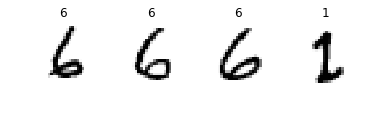

In [316]:
fig = plt.figure()
for i in range(0,4):
    sub_plot = fig.add_subplot(1,4,i+1)
    sub_plot.axis('Off')
    plt.imshow(mb_example[0][i,0].numpy() * std + mean, cmap='Greys', interpolation=None)
    sub_plot.set_title(mb_example[1][i])

# Create a model

It's always a good idea to create a model as a subclass of nn.Module. That way, we can use all the features this class provides.

We override the init function (but still call the init function of nn.Module) to define our custom layers (here two linear layers) and we have to define the forward function, which explains how to compute the output.

The first line of the forward function is to flatten our input, since we saw it has four dimensions: minibatch by channel by height by width. We only keep the minibatch size as our first dimension (x.size(0)) and the -1 is to tell pytorch to determine the right number for the second dimension.

In [319]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.linear1 = nn.Linear(n_in, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_out)
    
    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = F.relu(self.linear1(x))
        return F.log_softmax(self.linear2(x), dim=-1)

Then we can instanciate the class with our input size (28 * 28), an hidden size of 100 layers and 10 outputs (as many as digits).

The optimizer will automatically do the Stochastic Gradient Descent for us (or any of its variant if we want).

In [320]:
net = SimpleNeuralNet(28*28,100,10)
optimizer = optim.SGD(net.parameters(),lr=0.01)

Now we're ready to write our training loop. To compute the gradient automatically, pytorch requires us to put the torch tensors with our inputs and labels into Variable objects, that way it'll remember the transformation these go through until we arrive at our loss function. We then call loss.backward() to compute all the gradients (which will then be in the grad field of any variable).

The optimizer takes care of the step of our gradient descent in the optimizer.step() function. Since the gradients are accumulated, we have to tell pytorch when to reinitialize them (which the purpose of the optimizer.zero_grad() command at the beginning).

In [318]:
def train(nb_epoch):
    for epoch in range(nb_epoch):
        running_loss = 0.
        corrects = 0
        print(f'Epoch {epoch+1}:')
        for data in trn_loader:
            #separate the inputs from the labels
            inputs,labels = data
            #wrap those into variables to keep track of how they are created and be able to compute their gradient.
            inputs, labels = Variable(inputs), Variable(labels)
            #Put the gradients back to zero
            optimizer.zero_grad()
            #Compute the outputs given by our model at this stage.
            outputs = net(inputs)
            _,preds = torch.max(outputs.data,1)
            #Compute the loss
            loss = F.nll_loss(outputs, labels)
            running_loss += loss.data[0] * inputs.size(0)
            corrects += torch.sum(labels.data == preds)
            #Backpropagate the computation of the gradients
            loss.backward()
            #Do the step of the SGD
            optimizer.step()
        print(f'Loss: {running_loss/len(trn_set)}  Accuracy: {100.*corrects/len(trn_set)}')

Now we're ready to train our model.

In [280]:
train(10)

Epoch 1:
Loss: 0.5906580220858256  Accuracy: 84.88166666666666
Epoch 2:
Loss: 0.30375126430193583  Accuracy: 91.31333333333333
Epoch 3:
Loss: 0.2561927898168564  Accuracy: 92.635
Epoch 4:
Loss: 0.22466549276510875  Accuracy: 93.57833333333333
Epoch 5:
Loss: 0.2011491748770078  Accuracy: 94.23333333333333
Epoch 6:
Loss: 0.18185928338766097  Accuracy: 94.77
Epoch 7:
Loss: 0.16667112928231556  Accuracy: 95.25166666666667
Epoch 8:
Loss: 0.1536092581152916  Accuracy: 95.66166666666666
Epoch 9:
Loss: 0.1425275424003601  Accuracy: 96.00833333333334
Epoch 10:
Loss: 0.13277317984104156  Accuracy: 96.23333333333333


96.23% accuracy is good, but that's on the training set and we may be overfitting. Let's try on the test set now to see if we're doing well or not.

In [283]:
def validate():
    running_loss = 0.
    corrects = 0
    for data in tst_loader:
        #separate the inputs from the labels
        inputs,labels = data
        #wrap those into variables to keep track of how they are created and be able to compute their gradient.
        #Even if we don't require the gradient here, a nn.Module expects a variable.
        inputs, labels = Variable(inputs), Variable(labels)
        #Compute the outputs given by our model at this stage.
        outputs = net(inputs)
        _,preds = torch.max(outputs.data,1)
        #Compute the loss
        loss = F.nll_loss(outputs, labels)
        running_loss += loss.data[0] * inputs.size(0)
        corrects += torch.sum(labels.data == preds)
    print(f'Loss: {running_loss/len(tst_set)}  Accuracy: {100.*corrects/len(tst_set)}')

In [284]:
validate()

Loss: 0.13578992411643268  Accuracy: 96.03


So we weren't overfitting!